In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Testing Cutoffs ANN 0

In [3]:
# No. outputs
outputs = 1

# Files must be the same length
ANN_prefixes = ['LINER/ANNs/LINER_ANN_', 'planetary_nebula/ANNs/planetary_nebula_ANN_', 'seyfert/ANNs/seyfert_ANN_', 'star_forming/ANNs/star_forming_ANN_']
ANN_endings = ['5_10.keras', '6_20.keras', '7_30.keras', '8_40.keras', '9_50.keras', '10_60.keras', '11_70.keras', '12_80.keras', '13_90.keras', '0_100.keras', '1_200.keras', '2_300.keras', '3_400.keras', '4_500.keras', '14_600.keras', '15_700.keras', '16_800.keras', '17_900.keras', '18_1000.keras']
ANN_paths = []

for i in range(len(ANN_endings)):
    for j in range(len(ANN_prefixes)):
        ANN_paths.append(ANN_prefixes[j] + ANN_endings[i])

ANN_paths.sort()

file_paths = ['LINER/LINER_10_to_37_mod.txt', 'planetary_nebula/planetary_nebula_10_to_37_mod.txt', 'seyfert/seyfert_10_to_37_mod.txt', 'star_forming/star_forming_10_to_37_mod.txt'] * int(len(ANN_paths)/4)
ANN_names = []
no_epochs = []
file_paths.sort()

lines_present = []
status = []

In [4]:
for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]
    ANN_names.append(ANN_name)
    no_epochs.append(int(ANN_name.split('_')[-1]))

    data = np.loadtxt(file)

    test_data = data[:,:-outputs] # The amplitudes
    lines = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # YPred is the predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories
    lines = lines.T

    lines_present.append(lines.T)

    status.append(lines - YPred)

lines_present = np.array(lines_present)[:,0]
status = np.array(status).T[0]

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1750/1750 ━

In [5]:
# The cutoff for what is considered a spectrum
cutoffs = np.arange(0.001, 1.001, 0.001)

In [6]:
# Store values
tp = np.empty((len(status[0]), len(cutoffs)))
fp = np.empty((len(status[0]), len(cutoffs)))
fn = np.empty((len(status[0]), len(cutoffs)))
tn = np.empty((len(status[0]), len(cutoffs)))
total_wrong = np.empty((len(status[0]), len(cutoffs)))

# Loop over cutoff values
for j in range(len(cutoffs)):
    # Loop over sets of data
    for i in range(len(status[0])):
        real_det = np.dstack(np.where((status[:,i] >= 0) & (status[:,i] <= 1 - cutoffs[j])))[0]
        miss_det = np.dstack(np.where(status[:,i] > 1 - cutoffs[j]))[0]
        nothing = np.dstack(np.where((status[:,i] > 0 - cutoffs[j]) & (status[:,i] < 0)))[0]
        false_pos = np.dstack(np.where(status[:,i] <= 0 - cutoffs[j]))[0]

        total_incorrect = len(miss_det) + len(false_pos)

        # Confusion matrix overall
        confusion = np.array([[len(real_det), len(false_pos)], [len(miss_det), len(nothing)]], dtype='f')

        # Relative values
        no_false, no_lines = np.unique(lines_present[i], return_counts=True)[1]

        confusion[:,0] /= no_lines
        confusion[:,1] /= no_false

        total_incorrect /= (no_lines + no_false)

        tp[i,j] = confusion[0,0]
        fp[i,j] = confusion[0,1]
        fn[i,j] = confusion[1,0]
        tn[i,j] = confusion[1,1]
        total_wrong[i,j] = total_incorrect

In [7]:
# Find indices where incorrect classification is minimised

mins = np.array([], dtype=int)
min_overall = np.argmin(np.mean(fn + fp, axis=0))

for i in range(len(fn)):
    mins = np.append(mins, np.argmin(fn[i] + fp[i]))

print(cutoffs[mins])

fn_min = np.array([])
fp_min = np.array([])
total_wrong_min = np.array([])

# for i in range(len(ANN_names)):
#     plt.plot(cutoffs, fp[i] + fn[i], label=f'{no_epochs[i]} epochs')

for i in range(len(fn)):
  print(f'Cutoff with minimal incorrect classifciation for {ANN_names[i]} : {cutoffs[mins[i]]}')
  print(f'False negatives at this cutoff for {ANN_names[i]}: {fn[i][mins[i]]}')
  print(f'False positives at this cutoff for {ANN_names[i]}: {fp[i][mins[i]]}')
  print(f'Total incorrect classifications at this cutoff for {ANN_names[i]}: {fp[i][mins[i]]+fn[i][mins[i]]}\n')
  # plt.scatter(cutoffs[mins[i]], (fn + fp)[i][mins[i]])

  # Store the minimal fn and fp
  fn_min = np.append(fn_min, fn[i][mins[i]])
  fp_min = np.append(fp_min, fp[i][mins[i]])
  total_wrong_min = np.append(total_wrong_min, total_wrong[i][mins[i]])

print('Overall minimal incorrect classifciation')
print(f'Cutoff with minimal incorrect classifciation: {cutoffs[min_overall]}')
for i in range(len(fn)):
  print(f'False negatives at this cutoff for {ANN_names[i]}: {fn[i][min_overall]}')
  print(f'False positives at this cutoff for {ANN_names[i]}: {fp[i][min_overall]}')
  print(f'Total incorrect classifications at this cutoff for {ANN_names[i]}: {fp[i][mins[i]]+fn[i][mins[i]]}\n')

# plt.axvline(cutoffs[min_overall], color='black', linestyle='--')


# plt.yscale('log')
# plt.xlabel('Cutoff')
# plt.ylabel('Incorrect classification rate')
# plt.legend(loc=2)
# plt.show()

[0.578 0.501 0.419 0.478 0.521 0.798 0.826 0.806 0.835 0.866 0.576 0.587
 0.638 0.673 0.516 0.529 0.464 0.597 0.448 0.35  0.406 0.525 0.468 0.556
 0.468 0.479 0.606 0.792 0.512 0.468 0.601 0.479 0.558 0.628 0.516 0.433
 0.465 0.646 0.487 0.491 0.562 0.328 0.477 0.818 0.861 0.819 0.857 0.883
 0.5   0.559 0.451 0.732 0.764 0.615 0.603 0.563 0.526 0.56  0.452 0.563
 0.497 0.501 0.68  0.605 0.704 0.63  0.719 0.538 0.476 0.608 0.586 0.419
 0.554 0.508 0.498 0.565]
Cutoff with minimal incorrect classifciation for LINER_ANN_0_100 : 0.578
False negatives at this cutoff for LINER_ANN_0_100: 0.12410714477300644
False positives at this cutoff for LINER_ANN_0_100: 0.033642858266830444
Total incorrect classifications at this cutoff for LINER_ANN_0_100: 0.15775000303983688

Cutoff with minimal incorrect classifciation for LINER_ANN_10_60 : 0.501
False negatives at this cutoff for LINER_ANN_10_60: 0.12682142853736877
False positives at this cutoff for LINER_ANN_10_60: 0.030321428552269936
Total incor

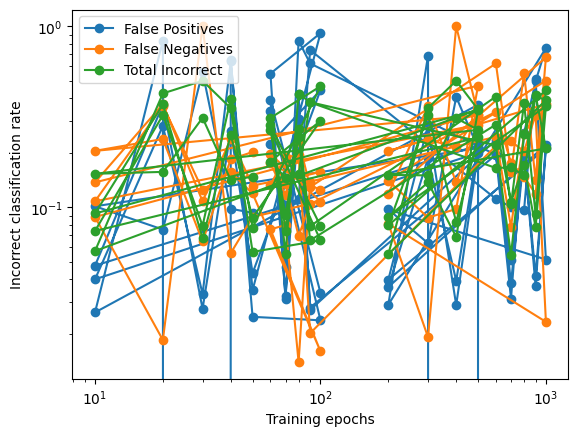

In [ ]:
plt.plot(no_epochs, fp_min, marker='o', label='False Positives')
plt.plot(no_epochs, fn_min, marker='o', label='False Negatives')
plt.plot(no_epochs, total_wrong_min, marker='o', label='Total Incorrect')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Training epochs')
plt.ylabel('Incorrect classification rate')
plt.legend(loc=2)
# plt.savefig('seyfert_epochs.png', dpi=600)
plt.show()


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


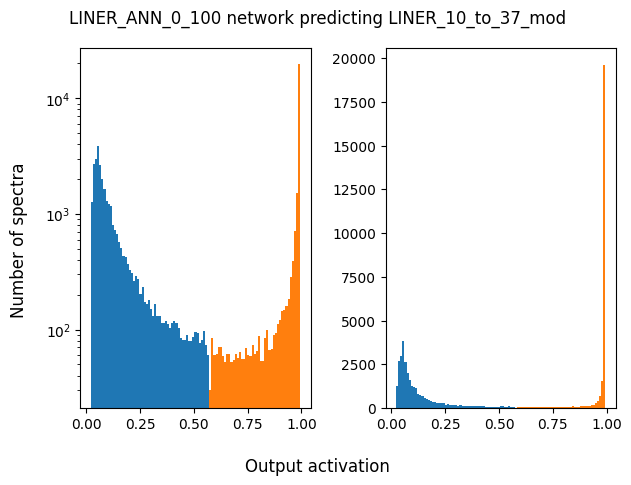

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


KeyboardInterrupt: 

In [ ]:
# The cutoff for what is considered a spectrum
cutoffs_min = cutoffs[mins]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]
    cutoff = cutoffs_min[i]

    data = np.loadtxt(file)

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # YPred is the predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    predicted_data = np.hstack((test_data, YPred))

    # Highlighting potential hits
    potential = predicted_data[np.unique(np.where(YPred > cutoff)[0]),:]

    # Create histograms for each peak
    hbin = np.linspace(min(YPred), max(YPred), num=100).reshape(-1)
    fig, ax = plt.subplots(1, 2)

    for j in range(2):
        ax[j].hist(YPred[np.where(YPred < cutoff)[0]], bins=hbin, density=False, label='Non-Detections')
        ax[j].hist(YPred[np.where(YPred > cutoff)[0]], bins=hbin, density=False, label='Potential Detections')

    fig.supxlabel('Output activation')
    fig.supylabel('Number of spectra')

    fig.suptitle(f'{ANN_name} network predicting {test_name}')
    ax[0].set_yscale('log')
    ax[1].set_yscale('linear')
    plt.tight_layout()
    plt.show()

In [ ]:
cutoffs_min = cutoffs[mins]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]
    cutoff = cutoffs_min[i]

    data = np.loadtxt(file)

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    # Best overall
    # Confusion matrix
    confusion = np.array([[tp[i,min_overall], fp[i,min_overall]], [fn[i,min_overall], tn[i,min_overall]]], dtype='f')

    ax = plt.gca()
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.imshow(confusion, cmap='Greys', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks([0, 1], ['Spectrum present', 'Spectrum not present'])
    plt.yticks([0, 1], ['Spectrum detected', 'Spectrum not detected'], rotation='vertical', va='center')
    plt.ylabel('Is the line detected?')
    plt.xlabel('Is the line present?')
    plt.title(f'Confusion matrix for all lines in {test_name}\nusing {ANN_name}, overall best')
    plt.text(0, 0, np.round(confusion[0][0], 5), ha='center', backgroundcolor='w')
    plt.text(0, 1, np.round(confusion[1][0], 5), ha='center', backgroundcolor='w')
    plt.text(1, 0, np.round(confusion[0][1], 5), ha='center', backgroundcolor='yellow')
    plt.text(1, 1, np.round(confusion[1][1], 5), ha='center', backgroundcolor='w')
    plt.show()

    # Best locally
    # Confusion matrix
    confusion = np.array([[tp[i,mins[i]], fp[i,mins[i]]], [fn[i,mins[i]], tn[i,mins[i]]]], dtype='f')

    ax = plt.gca()
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.imshow(confusion, cmap='Greys', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks([0, 1], ['Spectrum present', 'Spectrum not present'])
    plt.yticks([0, 1], ['Spectrum detected', 'Spectrum not detected'], rotation='vertical', va='center')
    plt.ylabel('Is the line detected?')
    plt.xlabel('Is the line present?')
    plt.title(f'Confusion matrix for all lines in {test_name}\nusing {ANN_name}, local best')
    plt.text(0, 0, np.round(confusion[0][0], 5), ha='center', backgroundcolor='w')
    plt.text(0, 1, np.round(confusion[1][0], 5), ha='center', backgroundcolor='w')
    plt.text(1, 0, np.round(confusion[0][1], 5), ha='center', backgroundcolor='yellow')
    plt.text(1, 1, np.round(confusion[1][1], 5), ha='center', backgroundcolor='w')
    plt.show()

In [9]:
# At what ANN does it work best
cutoffs_min = cutoffs[mins]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]
    cutoff = cutoffs_min[i]

    data = np.loadtxt(file)

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]


    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # The predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories and store AoNs
    lines_present = lines_present.T

    status = lines_present - YPred


    real_det = np.dstack(np.where((status >= 0) & (status <= 1 - cutoff)))[0]
    miss_det = np.dstack(np.where(status > 1 - cutoff))[0]
    nothing = np.dstack(np.where((status > 0 - cutoff) & (status < 0)))[0]
    false_pos = np.dstack(np.where(status <= 0 - cutoff))[0]

    if outputs != 1:
        real_AoNs = data[real_det[:,0], real_det[:,1]]
        miss_AoNs = data[miss_det[:,0], miss_det[:,1]]
        noth_AoNs = data[nothing[:,0], nothing[:,1]]
        false_AoNs = data[false_pos[:,0], false_pos[:,1]]
    else:
        real_AoNs = data[real_det[:,0], 4]
        miss_AoNs = data[miss_det[:,0], 4]
        noth_AoNs = data[nothing[:,0], 4]
        false_AoNs = data[false_pos[:,0], 4]

    # Create histograms
    no_bins = 100
    hbin = np.linspace(0, 10, no_bins)

    for cumulative in [True, False]:
        plt.hist(real_AoNs, bins=hbin, density=cumulative, label='real detections', histtype='step', cumulative=cumulative)
        plt.hist(miss_AoNs, bins=hbin, density=cumulative, label='missed detections', histtype='step', cumulative=cumulative)
        plt.hist(noth_AoNs, bins=hbin, density=cumulative, label='true negatives', histtype='step', cumulative=cumulative)
        plt.hist(false_AoNs, bins=hbin, density=cumulative, label='false positives', histtype='step', cumulative=cumulative)

        if cumulative == True:
            plt.title(f'A/N cumulative distribution of lines detected by\n{ANN_name}')
        else:
            plt.title(f'A/N distribution of lines detected by\n{ANN_name}')
        plt.xlabel('A/N out')
        plt.legend()
        plt.show()

        # The A/N of the false positives
        false_AoNs = data[false_pos[:,0], 4]
        false_AoNs = np.sort(false_AoNs)
        half = max(false_AoNs[0:int(len(false_AoNs)/2)])


        hbin = np.linspace(0, 10, no_bins)
        fig, ax = plt.subplots()
        cnts, values, bars = ax.hist(false_AoNs, bins=hbin, cumulative=cumulative, density=cumulative)
        for j, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
            if value < half:
                bar.set_facecolor('tab:blue')
            else:
                bar.set_facecolor('tab:orange')
        ax.set_title(r'A/N distribution of H$\alpha$'+f' line in false positives by\n{ANN_name}')
        ax.set_xlabel('A/N out')
        plt.show()

        # The A/N of the undetected spectra
        missed_AoNs = data[miss_det[:,0], 4]
        missed_AoNs = np.sort(missed_AoNs)
        half = max(missed_AoNs[0:int(len(missed_AoNs)/2)])

        hbin = np.linspace(0, 10, no_bins)
        fig, ax = plt.subplots()
        cnts, values, bars = ax.hist(missed_AoNs, bins=hbin, cumulative=cumulative, density=cumulative)
        for j, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
            if value < half:
                bar.set_facecolor('tab:blue')
            else:
                bar.set_facecolor('tab:orange')
        ax.set_title(r'A/N distribution of H$\alpha$'+f' line in missed detections by\n{ANN_name}')
        ax.set_xlabel('A/N out')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
# At what ANN does it work best
cutoffs_min = cutoffs[mins]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]
    cutoff = cutoffs_min[i]

    data = np.loadtxt(file)

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]


    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # The predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories and store AoNs
    lines_present = lines_present.T

    status = lines_present - YPred


    real_det = np.dstack(np.where((status >= 0) & (status <= 1 - cutoff)))[0]
    miss_det = np.dstack(np.where(status > 1 - cutoff))[0]
    nothing = np.dstack(np.where((status > 0 - cutoff) & (status < 0)))[0]
    false_pos = np.dstack(np.where(status <= 0 - cutoff))[0]

    if outputs != 1:
        real_AoNs = data[real_det[:,0], real_det[:,1]]
        miss_AoNs = data[miss_det[:,0], miss_det[:,1]]
        noth_AoNs = data[nothing[:,0], nothing[:,1]]
        false_AoNs = data[false_pos[:,0], false_pos[:,1]]
    else:
        real_AoNs = data[real_det[:,0], 4]
        miss_AoNs = data[miss_det[:,0], 4]
        noth_AoNs = data[nothing[:,0], 4]
        false_AoNs = data[false_pos[:,0], 4]

    # Create histograms
    no_bins = 100
    hbin = np.linspace(0, 10, no_bins)

    for cumulative in [True, False]:
        plt.hist(real_AoNs, bins=hbin, density=cumulative, label='real detections', histtype='step', cumulative=cumulative)
        plt.hist(miss_AoNs, bins=hbin, density=cumulative, label='missed detections', histtype='step', cumulative=cumulative)
        plt.hist(noth_AoNs, bins=hbin, density=cumulative, label='true negatives', histtype='step', cumulative=cumulative)
        plt.hist(false_AoNs, bins=hbin, density=cumulative, label='false positives', histtype='step', cumulative=cumulative)
        plt.xlabel('A/N out')
        plt.legend()
        if cumulative == True:
            plt.ylabel('Proportion')
            plt.savefig(f'histograms_out/all_cumulative_{ANN_name}.png', dpi=600)
        else:
            plt.ylabel('Count')
            plt.savefig(f'histograms_out/all_{ANN_name}.png', dpi=600)

        plt.show()

        # The A/N of the false positives
        false_AoNs = data[false_pos[:,0], 4]
        false_AoNs = np.sort(false_AoNs)
        half = max(false_AoNs[0:int(len(false_AoNs)/2)])


        hbin = np.linspace(0, 10, no_bins)
        fig, ax = plt.subplots()
        cnts, values, bars = ax.hist(false_AoNs, bins=hbin, cumulative=cumulative, density=cumulative)
        for j, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
            if value < half:
                bar.set_facecolor('tab:blue')
            else:
                bar.set_facecolor('tab:orange')
        ax.set_xlabel('A/N out')
        if cumulative == True:
            ax.set_ylabel('Proportion')
            plt.savefig(f'histograms_out/false_pos_cumulative_{ANN_name}.png', dpi=600)
        else:
            ax.set_ylabel('Count')
            plt.savefig(f'histograms_out/false_pos_{ANN_name}.png', dpi=600)
        plt.show()

        # The A/N of the undetected spectra
        missed_AoNs = data[miss_det[:,0], 4]
        missed_AoNs = np.sort(missed_AoNs)
        half = max(missed_AoNs[0:int(len(missed_AoNs)/2)])

        hbin = np.linspace(0, 10, no_bins)
        fig, ax = plt.subplots()
        cnts, values, bars = ax.hist(missed_AoNs, bins=hbin, cumulative=cumulative, density=cumulative)
        for j, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
            if value < half:
                bar.set_facecolor('tab:blue')
            else:
                bar.set_facecolor('tab:orange')
        ax.set_xlabel('A/N out')
        if cumulative == True:
            ax.set_ylabel('Proportion')
            plt.savefig(f'histograms_out/false_neg_cumulative_{ANN_name}.png', dpi=600)
        else:
            ax.set_ylabel('Count')
            plt.savefig(f'histograms_out/false_neg_{ANN_name}.png', dpi=600)
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

(array([[ 23.,  27.,  37.,  52.,  76., 101., 138., 179., 219., 246., 291.,
         320., 351., 389., 425., 455., 493., 528., 558., 581., 616., 655.,
         683., 707., 738., 761., 778., 800., 813., 828., 844., 854., 867.,
         877., 884., 889., 896., 903., 907., 910., 913., 918., 920., 922.,
         924., 924., 925., 927., 928., 929., 930., 930., 931., 932., 932.,
         933., 934., 934., 934., 934., 934., 936., 936., 937., 937., 937.,
         937., 937., 937., 938., 939., 939., 939., 940., 940., 940., 940.,
         940., 940., 940., 940., 941., 941., 941., 941., 941., 941., 941.,
         941., 941., 941., 941., 941., 941., 941., 941., 941., 941., 942.],
        [ 23.,  27.,  37.,  52.,  76., 101., 138., 179., 219., 246., 291.,
         320., 351., 389., 425., 455., 470., 470., 470., 470., 470., 470.,
         470., 470., 470., 470., 470., 470., 470., 470., 470., 470., 470.,
         470., 470., 470., 470., 470., 470., 470., 470., 470., 470., 470.,
         470., 470., 470

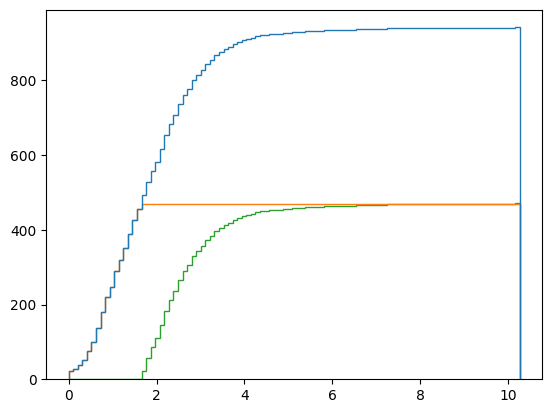

In [ ]:
false_AoNs = np.sort(false_AoNs)
half = max(false_AoNs[0:int(len(false_AoNs)/2)])

ind_over = np.where(false_AoNs > half)
ind_under = np.where(false_AoNs < half)



plt.hist([false_AoNs, false_AoNs[ind_under], false_AoNs[ind_over]], bins=hbin, density=False, histtype='step', cumulative=True)



In [ ]:
# Print in table format

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]
    ANN_epochs = ANN_name.split('_')[-1]

    print(f'{ANN_name} & {np.round(fp_min[i]*100, 3)} & {np.round(fn_min[i]*100, 3)} & {np.round(cutoffs[[mins[i]]], 3)[0]} & {ANN_epochs} \\\\ ')

LINER_ANN_0_100 & 3.364 & 12.411 & 0.578 & 100 \\ 
LINER_ANN_10_60 & 3.032 & 12.682 & 0.501 & 60 \\ 
LINER_ANN_11_70 & 3.814 & 11.95 & 0.419 & 70 \\ 
LINER_ANN_12_80 & 2.864 & 13.014 & 0.478 & 80 \\ 
LINER_ANN_13_90 & 2.789 & 12.918 & 0.521 & 90 \\ 
LINER_ANN_14_600 & 3.036 & 14.311 & 0.798 & 600 \\ 
LINER_ANN_15_700 & 2.911 & 14.779 & 0.826 & 700 \\ 
LINER_ANN_16_800 & 3.268 & 14.707 & 0.806 & 800 \\ 
LINER_ANN_17_900 & 4.175 & 14.15 & 0.835 & 900 \\ 
LINER_ANN_18_1000 & 4.143 & 13.929 & 0.866 & 1000 \\ 
LINER_ANN_1_200 & 3.086 & 12.775 & 0.576 & 200 \\ 
LINER_ANN_2_300 & 3.261 & 13.107 & 0.587 & 300 \\ 
LINER_ANN_3_400 & 2.879 & 13.732 & 0.638 & 400 \\ 
LINER_ANN_4_500 & 3.911 & 13.293 & 0.673 & 500 \\ 
LINER_ANN_5_10 & 3.529 & 12.386 & 0.516 & 10 \\ 
LINER_ANN_6_20 & 2.779 & 13.043 & 0.529 & 20 \\ 
LINER_ANN_7_30 & 3.314 & 12.471 & 0.464 & 30 \\ 
LINER_ANN_8_40 & 4.014 & 11.886 & 0.597 & 40 \\ 
LINER_ANN_9_50 & 3.175 & 12.468 & 0.448 & 50 \\ 
planetary_nebula_ANN_0_100 & 3.211 & 7.9

# Testing Cutoffs ANN 1

In [ ]:
# No. outputs
outputs = 1

# Files must be the same length
ANN_paths = ['LINER/LINER_0_to_9_mod_ANN_0.keras', 'planetary_nebula/planetary_nebula_0_to_9_mod_ANN_0.keras', 'seyfert/seyfert_0_to_9_mod_ANN_0.keras', 'star_forming/star_forming_0_to_9_mod_ANN_0.keras']
file_paths = ['LINER/LINER_10_to_37_mod.txt', 'planetary_nebula/planetary_nebula_10_to_37_mod.txt', 'seyfert/seyfert_10_to_37_mod.txt', 'star_forming/star_forming_10_to_37_mod.txt']

lines_present = []
status = []

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    test_data = data[:,:-outputs] # The amplitudes
    lines = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # YPred is the predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories
    lines = lines.T

    lines_present.append(lines.T)

    status.append(lines - YPred)

lines_present = np.array(lines_present)[:,0]
status = np.array(status).T[0]

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
# The cutoff for what is considered a line
cutoffs = np.arange(0.001, 1.001, 0.001)

# Store values
tp = np.empty((len(status[0]), len(cutoffs)))
fp = np.empty((len(status[0]), len(cutoffs)))
fn = np.empty((len(status[0]), len(cutoffs)))
tn = np.empty((len(status[0]), len(cutoffs)))

# Loop over cutoff values
for j in range(len(cutoffs)):
    # Loop over sets of data
    for i in range(len(status[0])):
      real_det = np.dstack(np.where((status[:,i] >= 0) & (status[:,i] <= 1 - cutoffs[j])))[0]
      miss_det = np.dstack(np.where(status[:,i] > 1 - cutoffs[j]))[0]
      nothing = np.dstack(np.where((status[:,i] > 0 - cutoffs[j]) & (status[:,i] < 0)))[0]
      false_pos = np.dstack(np.where(status[:,i] <= 0 - cutoffs[j]))[0]

      # Confusion matrix overall
      confusion = np.array([[len(real_det), len(false_pos)], [len(miss_det), len(nothing)]], dtype='f')

      # Relative values
      no_false, no_lines = np.unique(lines_present[i], return_counts=True)[1]

      confusion[:,0] /= no_lines
      confusion[:,1] /= no_false

      tp[i,j] = confusion[0,0]
      fp[i,j] = confusion[0,1]
      fn[i,j] = confusion[1,0]
      tn[i,j] = confusion[1,1]

[0.649 0.589 0.732 0.58 ]
Cutoff with minimal incorrect classifciation for LINER_0_to_9_mod_ANN_0 : 0.649
False negatives at this cutoff for LINER_0_to_9_mod_ANN_0: 0.141928568482399
False positives at this cutoff for LINER_0_to_9_mod_ANN_0: 0.03292857110500336

Cutoff with minimal incorrect classifciation for planetary_nebula_0_to_9_mod_ANN_0 : 0.589
False negatives at this cutoff for planetary_nebula_0_to_9_mod_ANN_0: 0.08246428519487381
False positives at this cutoff for planetary_nebula_0_to_9_mod_ANN_0: 0.032999999821186066

Cutoff with minimal incorrect classifciation for seyfert_0_to_9_mod_ANN_0 : 0.732
False negatives at this cutoff for seyfert_0_to_9_mod_ANN_0: 0.11328571289777756
False positives at this cutoff for seyfert_0_to_9_mod_ANN_0: 0.028392856940627098

Cutoff with minimal incorrect classifciation for star_forming_0_to_9_mod_ANN_0 : 0.58
False negatives at this cutoff for star_forming_0_to_9_mod_ANN_0: 0.2293928563594818
False positives at this cutoff for star_forming

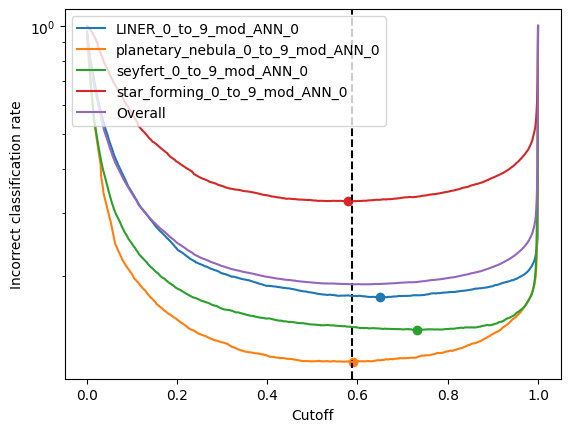

In [ ]:
# Find indices where incorrect classification is minimised

mins = np.array([], dtype=int)
min_overall = np.argmin(np.mean(fn + fp, axis=0))

for i in range(len(fn)):
    mins = np.append(mins, np.argmin(fn[i] + fp[i]))

print(cutoffs[mins])

ANN_names = []

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]
    ANN_names.append(ANN_name)





for i in range(len(fn)):
  print(f'Cutoff with minimal incorrect classifciation for {ANN_names[i]} : {cutoffs[mins[i]]}')
  print(f'False negatives at this cutoff for {ANN_names[i]}: {fn[i][mins[i]]}')
  print(f'False positives at this cutoff for {ANN_names[i]}: {fp[i][mins[i]]}\n')
  plt.scatter(cutoffs[mins[i]], (fn + fp)[i][mins[i]])

print('Overall minimal incorrect classifciation')
print(f'Cutoff with minimal incorrect classifciation: {cutoffs[min_overall]}')
for i in range(len(fn)):
  print(f'False negatives at this cutoff for {ANN_names[i]}: {fn[i][min_overall]}')
  print(f'False positives at this cutoff for {ANN_names[i]}: {fp[i][min_overall]}\n')

plt.axvline(cutoffs[min_overall], color='black', linestyle='--')

for i in range(len(ANN_names)):
    plt.plot(cutoffs, fn[i] + fp[i], label=ANN_names[i])
plt.plot(cutoffs, np.mean(fn+fp, axis=0), label='Overall')
plt.yscale('log')
plt.xlabel('Cutoff')
plt.ylabel('Incorrect classification rate')
plt.legend(loc=2)
plt.show()

In [ ]:
for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]


    print(f'{ANN_name} & {np.round(fp[i, mins[i]]*100, 3)} & {np.round(fn[i, mins[i]]*100, 3)} & {cutoffs[mins[i]]} & 500 \\\\ ')

LINER_0_to_9_mod_ANN_0 & 3.293 & 14.193 & 0.649 & 500 \\ 
planetary_nebula_0_to_9_mod_ANN_0 & 3.3 & 8.246 & 0.589 & 500 \\ 
seyfert_0_to_9_mod_ANN_0 & 2.839 & 11.329 & 0.732 & 500 \\ 
star_forming_0_to_9_mod_ANN_0 & 9.443 & 22.939 & 0.58 & 500 \\ 


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


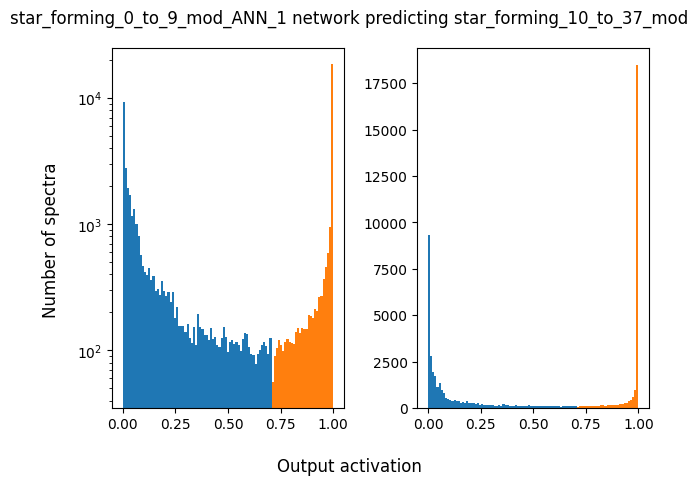

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


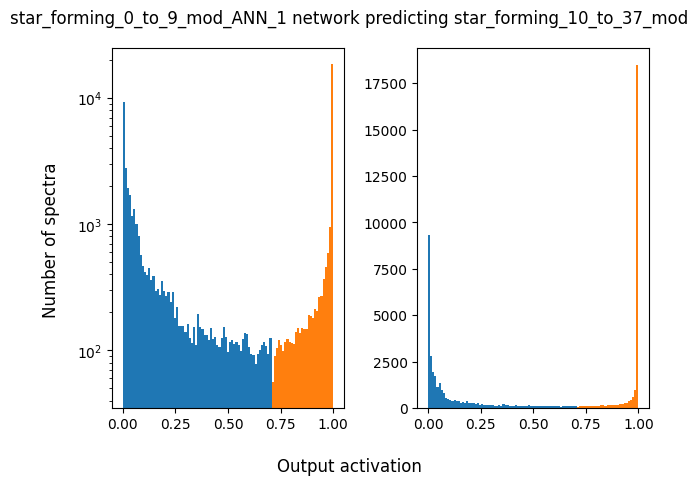

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


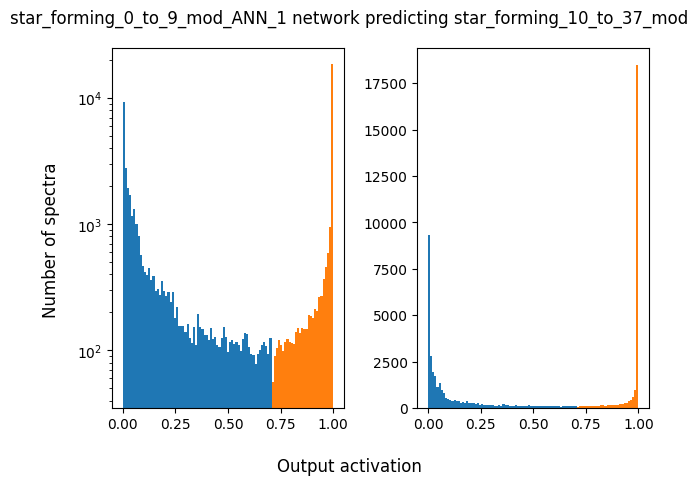

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


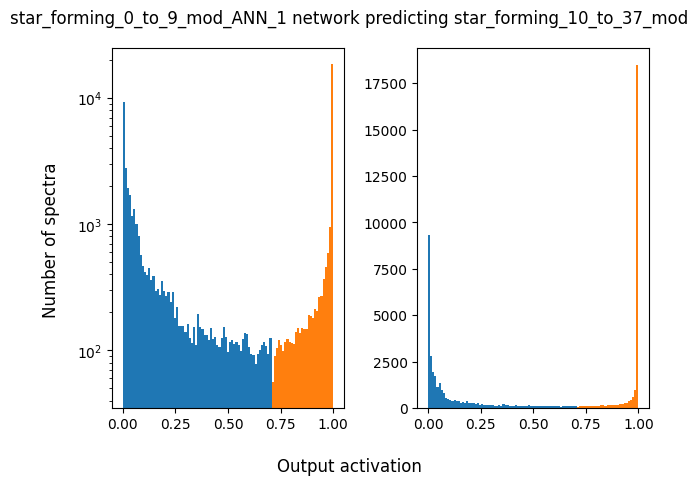

In [ ]:
# The cutoff for what is considered a line
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # YPred is the predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    predicted_data = np.hstack((test_data, YPred))

    # Highlighting potential hits
    potential = predicted_data[np.unique(np.where(YPred > cutoff)[0]),:]

    # Create histograms for each peak
    hbin = np.linspace(min(YPred), max(YPred), num=100).reshape(-1)
    fig, ax = plt.subplots(1, 2)

    for j in range(2):
        ax[j].hist(YPred[np.where(YPred < cutoff)[0]], bins=hbin, density=False, label='Non-Detections')
        ax[j].hist(YPred[np.where(YPred > cutoff)[0]], bins=hbin, density=False, label='Potential Detections')

    fig.supxlabel('Output activation')
    fig.supylabel('Number of spectra')

    fig.suptitle(f'{ANN_name} network predicting {test_name}')
    ax[0].set_yscale('log')
    ax[1].set_yscale('linear')
    plt.tight_layout()
    plt.show()

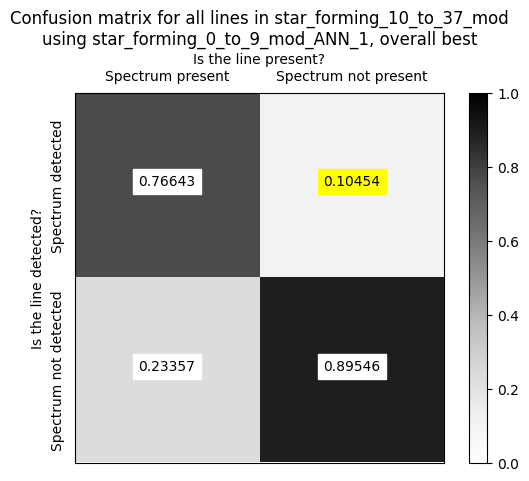

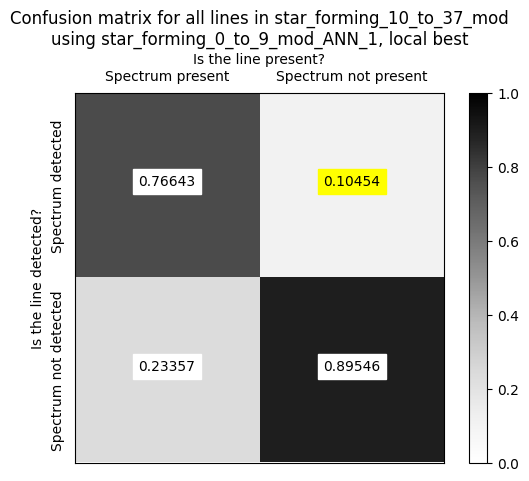

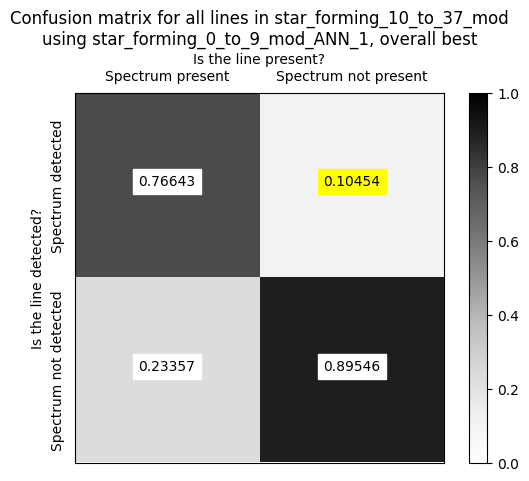

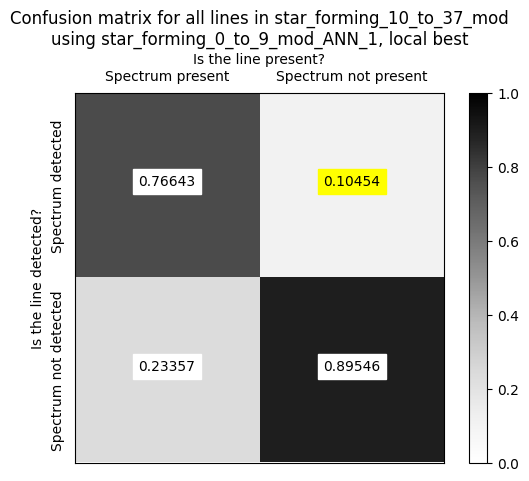

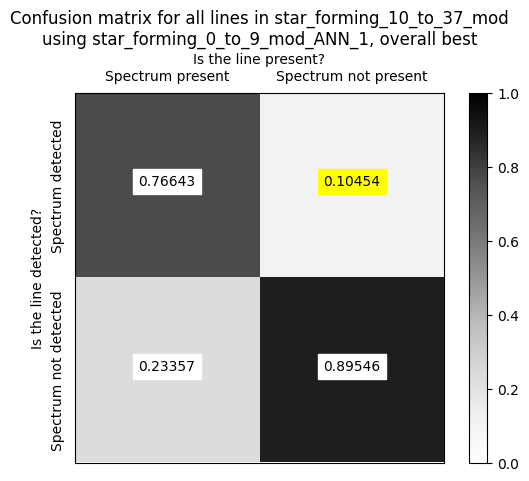

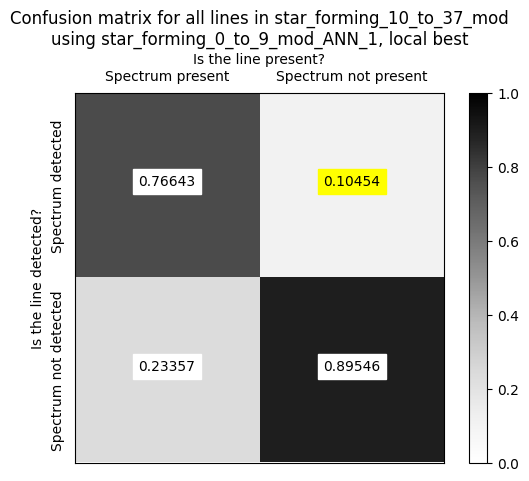

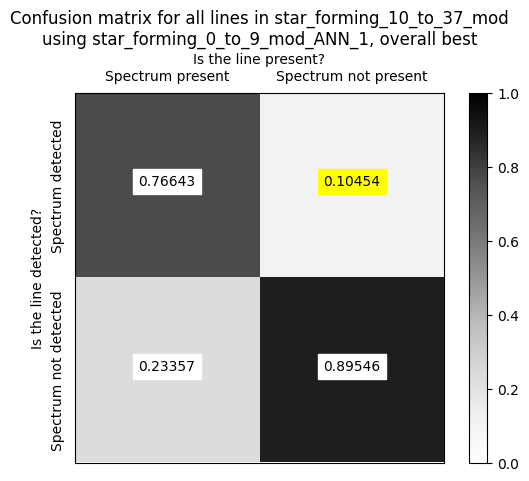

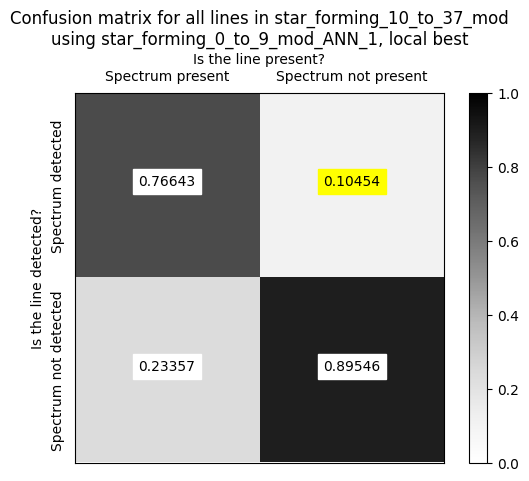

In [ ]:
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    # Best overall
    # Confusion matrix
    confusion = np.array([[tp[i,min_overall], fp[i,min_overall]], [fn[i,min_overall], tn[i,min_overall]]], dtype='f')

    ax = plt.gca()
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.imshow(confusion, cmap='Greys', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks([0, 1], ['Spectrum present', 'Spectrum not present'])
    plt.yticks([0, 1], ['Spectrum detected', 'Spectrum not detected'], rotation='vertical', va='center')
    plt.ylabel('Is the line detected?')
    plt.xlabel('Is the line present?')
    plt.title(f'Confusion matrix for all lines in {test_name}\nusing {ANN_name}, overall best')
    plt.text(0, 0, np.round(confusion[0][0], 5), ha='center', backgroundcolor='w')
    plt.text(0, 1, np.round(confusion[1][0], 5), ha='center', backgroundcolor='w')
    plt.text(1, 0, np.round(confusion[0][1], 5), ha='center', backgroundcolor='yellow')
    plt.text(1, 1, np.round(confusion[1][1], 5), ha='center', backgroundcolor='w')
    plt.show()

    # Best locally
    # Confusion matrix
    confusion = np.array([[tp[i,mins[i]], fp[i,mins[i]]], [fn[i,mins[i]], tn[i,mins[i]]]], dtype='f')

    ax = plt.gca()
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    plt.imshow(confusion, cmap='Greys', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks([0, 1], ['Spectrum present', 'Spectrum not present'])
    plt.yticks([0, 1], ['Spectrum detected', 'Spectrum not detected'], rotation='vertical', va='center')
    plt.ylabel('Is the line detected?')
    plt.xlabel('Is the line present?')
    plt.title(f'Confusion matrix for all lines in {test_name}\nusing {ANN_name}, local best')
    plt.text(0, 0, np.round(confusion[0][0], 5), ha='center', backgroundcolor='w')
    plt.text(0, 1, np.round(confusion[1][0], 5), ha='center', backgroundcolor='w')
    plt.text(1, 0, np.round(confusion[0][1], 5), ha='center', backgroundcolor='yellow')
    plt.text(1, 1, np.round(confusion[1][1], 5), ha='center', backgroundcolor='w')
    plt.show()

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


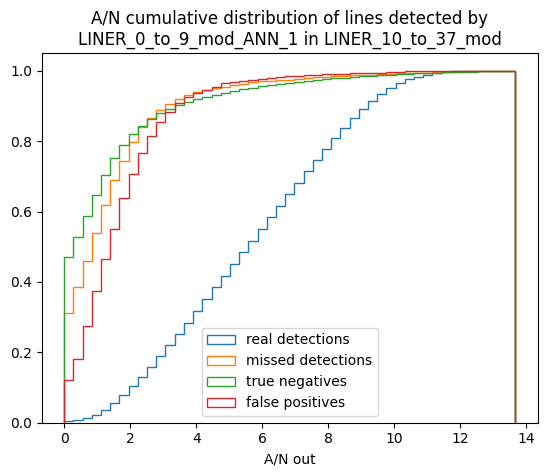

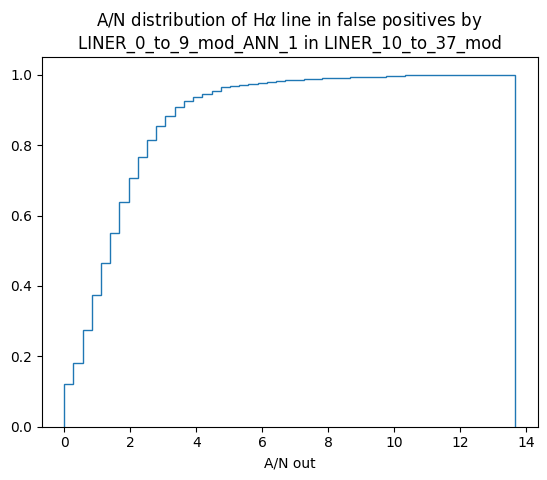

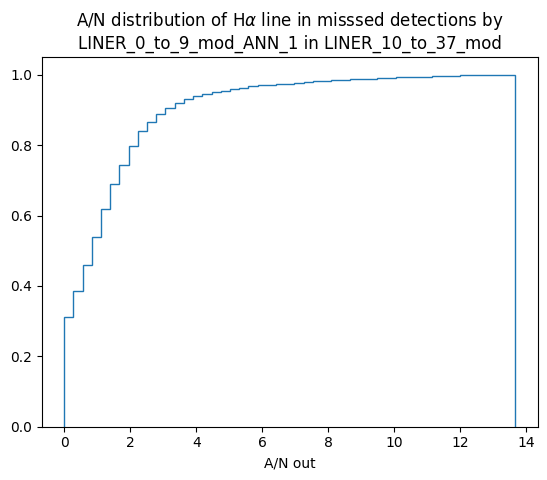

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


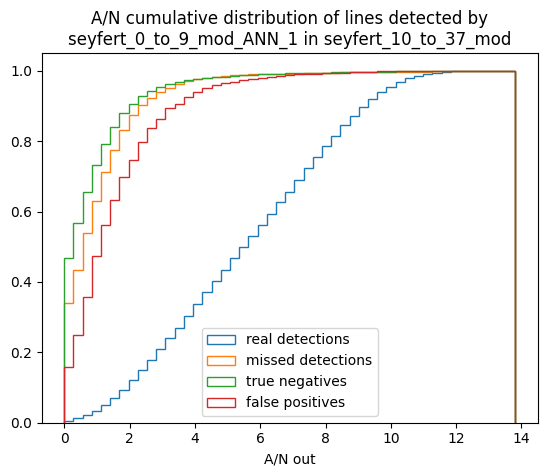

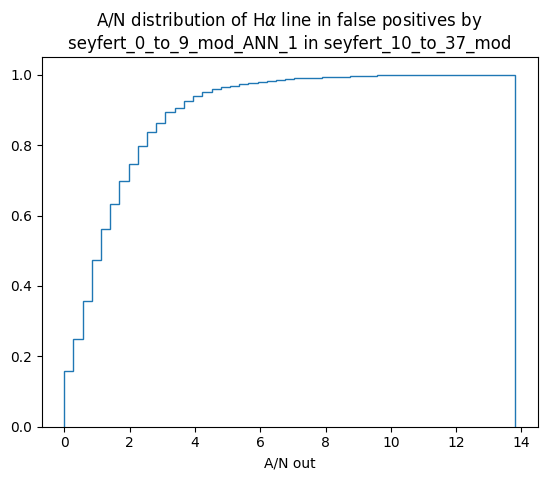

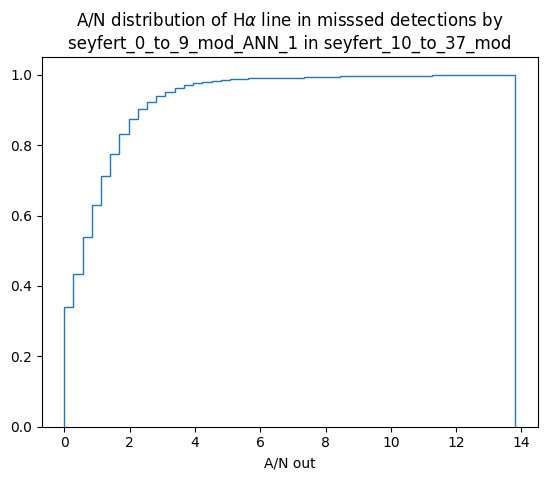

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


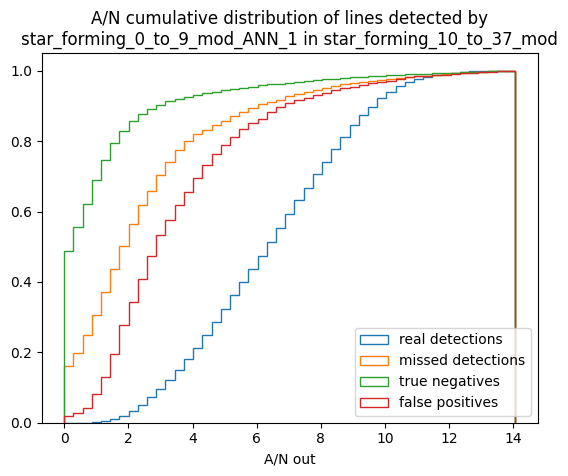

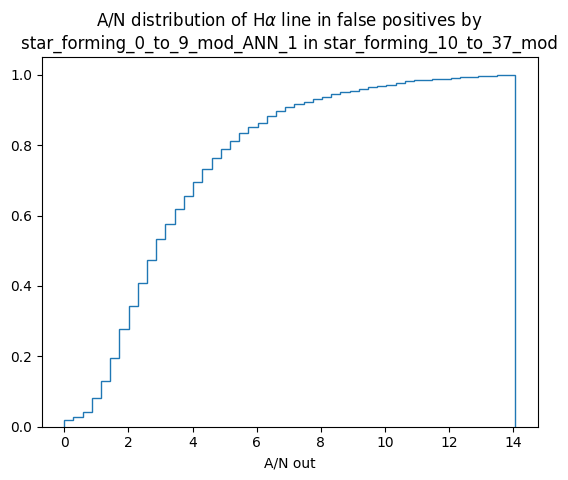

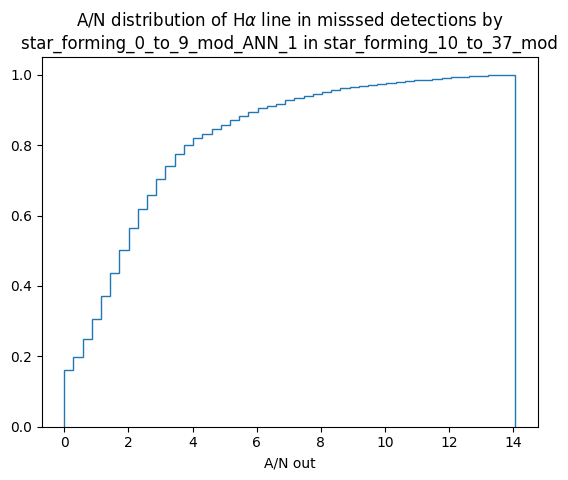

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


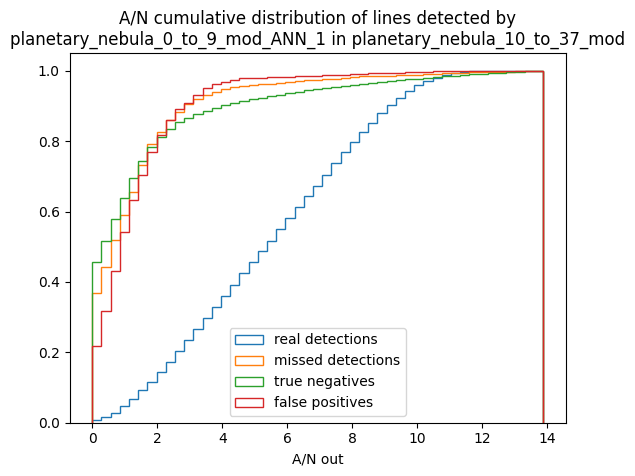

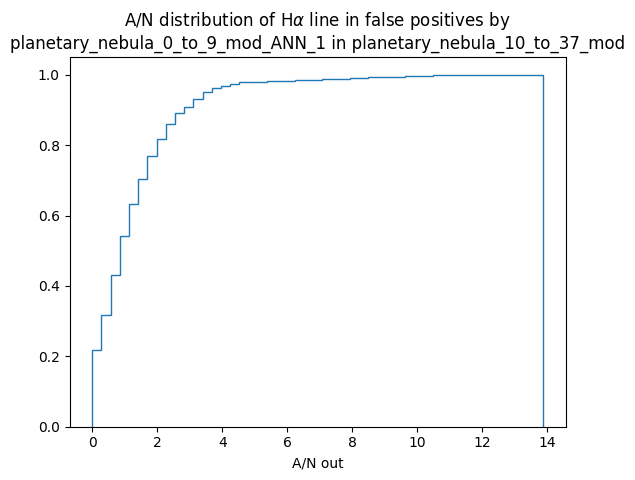

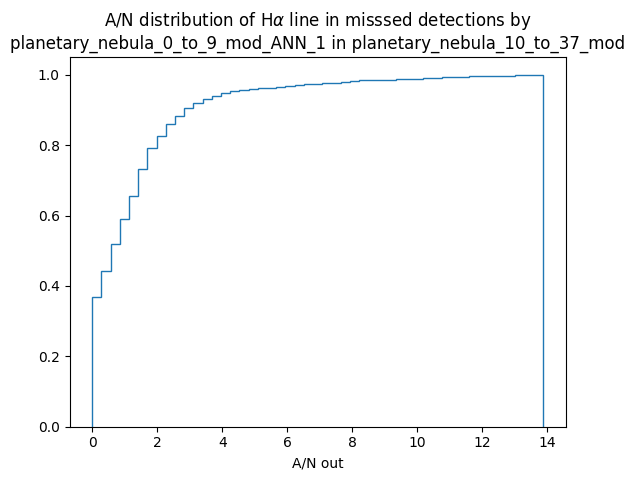

In [ ]:
# At what ANN does it work best
cutoff = cutoffs[min_overall]

for i in range(len(ANN_paths)):
    ANN = ANN_paths[i]
    file = file_paths[i]

    data = np.loadtxt(file)

    ANN_path = os.path.splitext(ANN)[0]
    ANN_name = ANN_path.split('/')[-1]

    filepath = os.path.splitext(file)[0]
    test_name = filepath.split('/')[-1]


    test_data = data[:,:-outputs] # The amplitudes
    lines_present = data[:,-outputs:].T # Whether the lines are present or not

    model = tf.keras.models.load_model(ANN)

    # The predicted value from the network
    YPred = model.predict(test_data, verbose=1)

    # Separate the lines into the different categories and store AoNs
    lines_present = lines_present.T

    status = lines_present - YPred


    real_det = np.dstack(np.where((status >= 0) & (status <= 1 - cutoff)))[0]
    miss_det = np.dstack(np.where(status > 1 - cutoff))[0]
    nothing = np.dstack(np.where((status > 0 - cutoff) & (status < 0)))[0]
    false_pos = np.dstack(np.where(status <= 0 - cutoff))[0]

    if outputs != 1:
        real_AoNs = data[real_det[:,0], real_det[:,1]]
        miss_AoNs = data[miss_det[:,0], miss_det[:,1]]
        noth_AoNs = data[nothing[:,0], nothing[:,1]]
        false_AoNs = data[false_pos[:,0], false_pos[:,1]]
    else:
        real_AoNs = data[real_det[:,0], 4]
        miss_AoNs = data[miss_det[:,0], 4]
        noth_AoNs = data[nothing[:,0], 4]
        false_AoNs = data[false_pos[:,0], 4]

    # Create histograms
    density = True
    cumulative = True
    no_bins = 50

    hbin = np.linspace(0, np.median(real_AoNs) + 3*np.std(real_AoNs), no_bins)
    plt.hist(real_AoNs, bins=hbin, density=density, label='real detections', histtype='step', cumulative=cumulative)
    plt.hist(miss_AoNs, bins=hbin, density=density, label='missed detections', histtype='step', cumulative=cumulative)
    plt.hist(noth_AoNs, bins=hbin, density=density, label='true negatives', histtype='step', cumulative=cumulative)
    plt.hist(false_AoNs, bins=hbin, density=density, label='false positives', histtype='step', cumulative=cumulative)

    if cumulative == True:
        plt.title(f'A/N cumulative distribution of lines detected by\n{ANN_name} in {test_name}')
    else:
        plt.title(f'A/N distribution of lines detected by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.legend()
    plt.show()

    # The A/N of the false positives
    false_AoNs = data[false_pos[:,0], 4]

    plt.hist(false_AoNs, bins=hbin, density=density, histtype='step', cumulative=cumulative)
    plt.title(r'A/N distribution of H$\alpha$'+f' line in false positives by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.show()

    # The A/N of the undetected spectra
    missed_AoNs = data[miss_det[:,0], 4]

    plt.hist(missed_AoNs, bins=hbin, density=density, histtype='step', cumulative=cumulative)
    plt.title(r'A/N distribution of H$\alpha$'+f' line in misssed detections by\n{ANN_name} in {test_name}')
    plt.xlabel('A/N out')
    plt.show()

In [ ]:
fn[0, mins[0]]

0.14225000143051147